In [2]:
import cv2, os, sys
import pandas as pd
import json
import numpy as np
import random
from icecream import ic
from tqdm.auto import tqdm
import shutil as sh

from matplotlib import pyplot as plt 
from matplotlib.patches import Rectangle
from PIL import Image
import PIL.ImageDraw as ImageDraw
from PIL import ImageColor

# Ignore warnings
import warnings
warnings.filterwarnings('ignore') 

In [3]:
root_directory = sys.path[0]  # current directory
file_path = os.path.join(root_directory, 'Data', 'Annotations', 'annotated_functional_test3_fixed.json')

with open(file_path) as json_data:
    data = json.load(json_data)

id_list = [i['id'] for i in data['images']]
file_name_list = [i['file_name'] for i in data['images']]
width_list = [i['width'] for i in data['images']]
height_list = [i['height'] for i in data['images']]
data_image = pd.DataFrame({'id':id_list, 'file_name':file_name_list, 'width':width_list, 'height':height_list})

ic(len(data_image.id))
data_image.head()

ic| len(data_image.id): 9585


id                                          file_name  width  height
0  7057517  8f27c5f1-3ea3-4392-9bc8-585c76057cd1/858a0246-...   1920    1200
1  7073954  f58a99ab-350a-41df-8dbf-889326378c4a/858a0246-...   1920    1200
2  7074070  f58a99ab-350a-41df-8dbf-889326378c4a/e84bd41d-...   1920    1200
3  7062766  b44a2093-2861-402b-96bd-23cac6359b94/e84bd41d-...   1920    1200
4  7060727  aac64f05-470c-4182-8417-0587f1e83e43/858a0246-...   1920    1200

In [4]:
segmentation_list = [i['segmentation'] for i in data['annotations']]
bbox_list = [i['bbox'] for i in data['annotations']]
iscrowd_list = [i['iscrowd'] for i in data['annotations']]
id_list = [i['id'] for i in data['annotations']]
image_id_list = [i['image_id'] for i in data['annotations']]
category_id_list = [i['category_id'] for i in data['annotations']]
area_list = [i['area'] for i in data['annotations']]

data_annotations = pd.DataFrame({'segmentation':segmentation_list,
                                 'bbox':bbox_list,
                                 'iscrowd':iscrowd_list, 
                                 'id':id_list, 
                                 'image_id':image_id_list, 
                                 'category_id':category_id_list, 
                                 'area':area_list})
data_annotations['segmentation'] = data_annotations.segmentation.apply(lambda x: x[0])

file_name = []
width = []
height = []
for i in data_annotations.image_id:
    fn = data_image[data_image.id.isin([i])].file_name.values  # <class 'numpy.ndarray'>
    file_name.append(''.join(fn))  # omit [''] 
    w = data_image[data_image.id.isin([i])].width.values 
    width.append(int(w))
    h = data_image[data_image.id.isin([i])].height.values
    height.append(int(h))

data_annotations['file_name'] = file_name
data_annotations['width'] = width
data_annotations['height'] = height
data_annotations = data_annotations[['file_name', 'image_id', 'id', 'width', 'height', 'bbox', 'segmentation', 'area', 'iscrowd', 'category_id']]

ic(len(data_annotations.image_id))
data_annotations.head()

ic| len(data_annotations.image_id): 897


file_name  image_id      id  width  \
0  8f27c5f1-3ea3-4392-9bc8-585c76057cd1/858a0246-...   7057517  504548   1920   
1  f58a99ab-350a-41df-8dbf-889326378c4a/858a0246-...   7073954  504081   1920   
2  f58a99ab-350a-41df-8dbf-889326378c4a/858a0246-...   7073954  504082   1920   
3  f58a99ab-350a-41df-8dbf-889326378c4a/e84bd41d-...   7074070  504086   1920   
4  b44a2093-2861-402b-96bd-23cac6359b94/e84bd41d-...   7062766  504658   1920   

   height                  bbox                                  segmentation  \
0    1200   [1050, 649, 65, 52]  [1050, 649, 1115, 649, 1115, 701, 1050, 701]   
1    1200   [1589, 534, 26, 37]  [1589, 534, 1615, 534, 1615, 571, 1589, 571]   
2    1200   [1354, 453, 36, 27]  [1354, 453, 1390, 453, 1390, 480, 1354, 480]   
3    1200   [902, 1084, 76, 57]  [902, 1084, 978, 1084, 978, 1141, 902, 1141]   
4    1200  [1324, 781, 97, 103]  [1324, 781, 1421, 781, 1421, 884, 1324, 884]   

   area  iscrowd  category_id  
0  3380        0            1  
1   962        0            1  
2   972        0            1  
3  4332        0            1  
4  9991        0            1

In [5]:
data_bbox= pd.DataFrame({})
data_bbox['file_name'] = data_annotations.file_name
data_bbox['image_id'] = data_annotations.image_id
data_bbox['id'] = data_annotations.id
data_bbox['x_min'] = data_annotations.segmentation.apply(lambda x: x[0]) 
data_bbox['y_min'] = data_annotations.segmentation.apply(lambda x: x[1]) 
data_bbox['x_max'] = data_annotations.segmentation.apply(lambda x: x[4]) 
data_bbox['y_max'] = data_annotations.segmentation.apply(lambda x: x[5]) 
data_bbox['width'] = data_annotations.bbox.apply(lambda x: x[2]) 
data_bbox['height'] = data_annotations.bbox.apply(lambda x: x[3]) 

ic(len(data_bbox.image_id))
data_bbox.head()

ic| len(data_bbox.image_id): 897


file_name  image_id      id  x_min  \
0  8f27c5f1-3ea3-4392-9bc8-585c76057cd1/858a0246-...   7057517  504548   1050   
1  f58a99ab-350a-41df-8dbf-889326378c4a/858a0246-...   7073954  504081   1589   
2  f58a99ab-350a-41df-8dbf-889326378c4a/858a0246-...   7073954  504082   1354   
3  f58a99ab-350a-41df-8dbf-889326378c4a/e84bd41d-...   7074070  504086    902   
4  b44a2093-2861-402b-96bd-23cac6359b94/e84bd41d-...   7062766  504658   1324   

   y_min  x_max  y_max  width  height  
0    649   1115    701     65      52  
1    534   1615    571     26      37  
2    453   1390    480     36      27  
3   1084    978   1141     76      57  
4    781   1421    884     97     103

In [34]:
bbox_image_path = os.path.join(root_directory, 'bbox_image')

# sh.rmtree(bbox_image_path)  # delete this folder
# if file don't exist, then create
try:
    os.makedirs(bbox_image_path)
except:
    print ("Directory bbox_image_path already exist.")

for i in data_bbox.id:
    tmp = data_annotations[data_annotations.id.isin([i])].file_name
    i_p = ' '.join(tmp)  # omit duplicated file name, '../...jpeg'
    img_path = os.path.join(root_directory, 'Data', 'Images', i_p)  # original data path
    file, ext = os.path.splitext(img_path)  # ('c:\\csv\\test', '.csv')

    im = Image.open(img_path)
    # Cropped image (It will not change orginal image) 
    one_row = data_bbox[data_bbox.id.isin([i])]

    im_ = im.crop((one_row.x_min, one_row.y_min, one_row.x_max, one_row.y_max)) 
    im_.save(os.path.join(bbox_image_path, str(i)+ext))  # , quality=95

## Label

current image_id is 7057517 and current id is 504548
1: Rim, 2: Scratch, 3: Dent, 4: Other
current image_id is 7073954 and current id is 504081
1: Rim, 2: Scratch, 3: Dent, 4: Other


ValueError: invalid literal for int() with base 10: ''

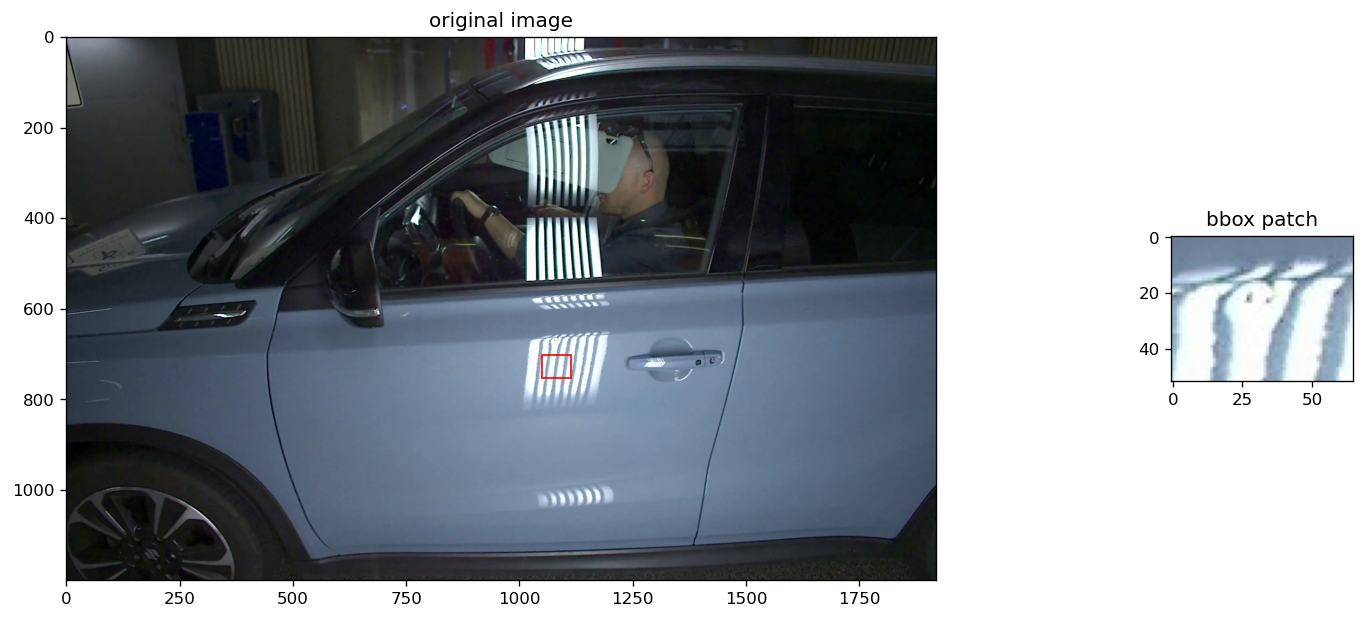

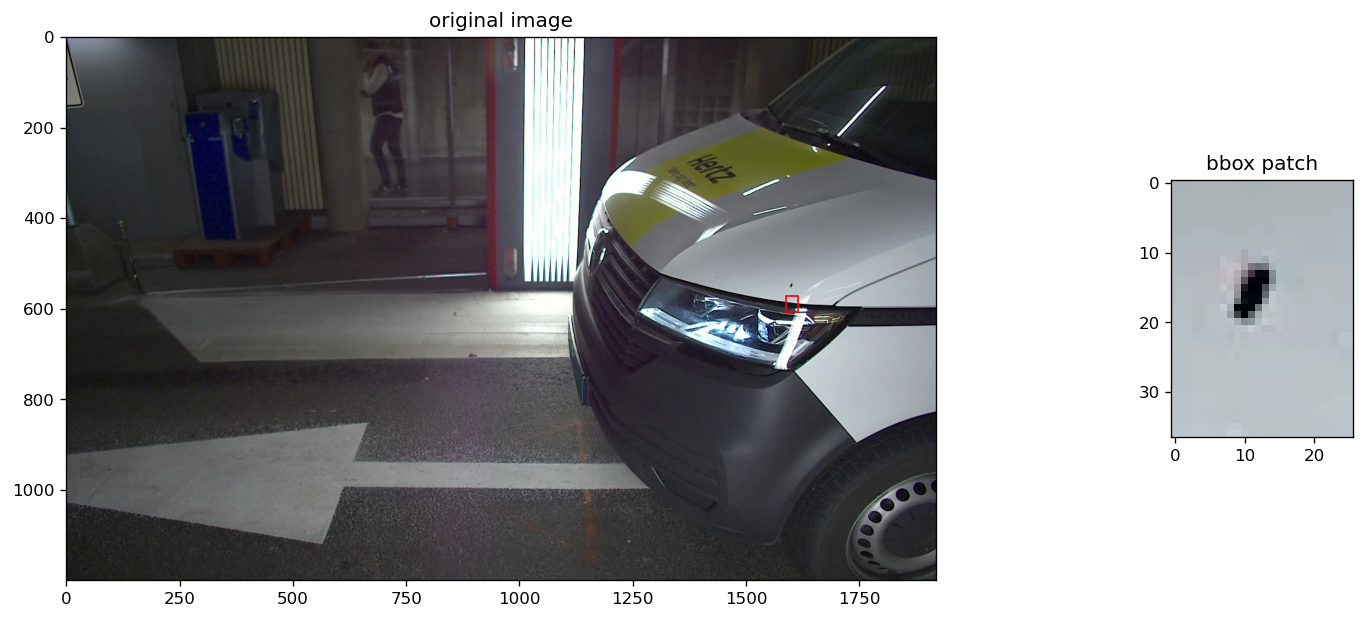

In [34]:
label_dict = {'1': 'Rim', '2': 'Scratch', '3': 'Dent', '4': 'Other'}   # dictionary{label:name} 
save_label = pd.DataFrame(columns=['image_id', 'id', 'human_label', 'label_name'])

tmp = data_bbox[:5]  # the number of images that you want to label
for i,name in enumerate(zip(tmp.file_name, tmp.image_id, tmp.id)):

    # get one row in data_bbox
    img_path = os.path.join(root_directory, 'Data', 'Images', name[0])
    one_row = data_bbox[data_bbox.id.isin([name[2]])]
    left = int(one_row.x_min)
    top = int(one_row.y_min)
    right = int(one_row.x_max)
    bottom = int(one_row.y_max)
    width = int(one_row.width)
    height = int(one_row.height)

    # prompt
    print(f'current image_id is {one_row.image_id.values[0]} and current id is {one_row.id.values[0]}')
    print('1: Rim, 2: Scratch, 3: Dent, 4: Other')

    # draw original image and bbox patch
    plt.ion()  # Turn the interactive mode on.
    figure, axis = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [6, 1]}, figsize=(15,6), dpi=120)
    img1 = Image.open(img_path)
    img2 = img1.crop((left, top, right, bottom))
    axis[0].imshow(img1)
    axis[0].add_patch(Rectangle((left,bottom), width, height, fc='none', color='red', linewidth=1, linestyle="-"))
    axis[0].set_title("original image")
    axis[1].imshow(img2)
    axis[1].set_title("bbox patch")

    # type label
    label = int(input("Please input a number: "))  # enter a number
    save_label.loc[i] = [one_row.image_id.values[0], one_row.id.values[0], label, label_dict[str(label)]]

save_label_path = os.path.join(root_directory, 'save_label.csv')
save_label_path1 = os.path.join(root_directory, 'save_label.json')
save_label.to_csv(save_label_path, index=False, header=True)
save_label.to_json(save_label_path1, orient='records')
print("file has already saved.")

In [57]:
# a=data_bbox.iloc[1]
# temp = []
# for i in a[1:]:
#     temp.append(i)
# [image_id, id, left, top, right, bottom, width, height] = temp

# left

# for i,name in enumerate(data_bbox.iloc[:5,:]):
#     print(name)

for i,name in data_bbox.iloc[:1,:].iterrows():
    print(name)
[file_name, image_id, id, left, top, right, bottom, width, height] = name
type(image_id)

file_name    8f27c5f1-3ea3-4392-9bc8-585c76057cd1/858a0246-...
image_id                                               7057517
id                                                      504548
x_min                                                     1050
y_min                                                      649
x_max                                                     1115
y_max                                                      701
width                                                       65
height                                                      52
Name: 0, dtype: object


int

current image_id is 7057517 and current id is 504548
1: Rim, 2: Scratch, 3: Dent, 4: Other
current image_id is 7073954 and current id is 504081
1: Rim, 2: Scratch, 3: Dent, 4: Other
current image_id is 7073954 and current id is 504082
1: Rim, 2: Scratch, 3: Dent, 4: Other
current image_id is 7074070 and current id is 504086
1: Rim, 2: Scratch, 3: Dent, 4: Other
current image_id is 7062766 and current id is 504658
1: Rim, 2: Scratch, 3: Dent, 4: Other


ValueError: invalid literal for int() with base 10: ''

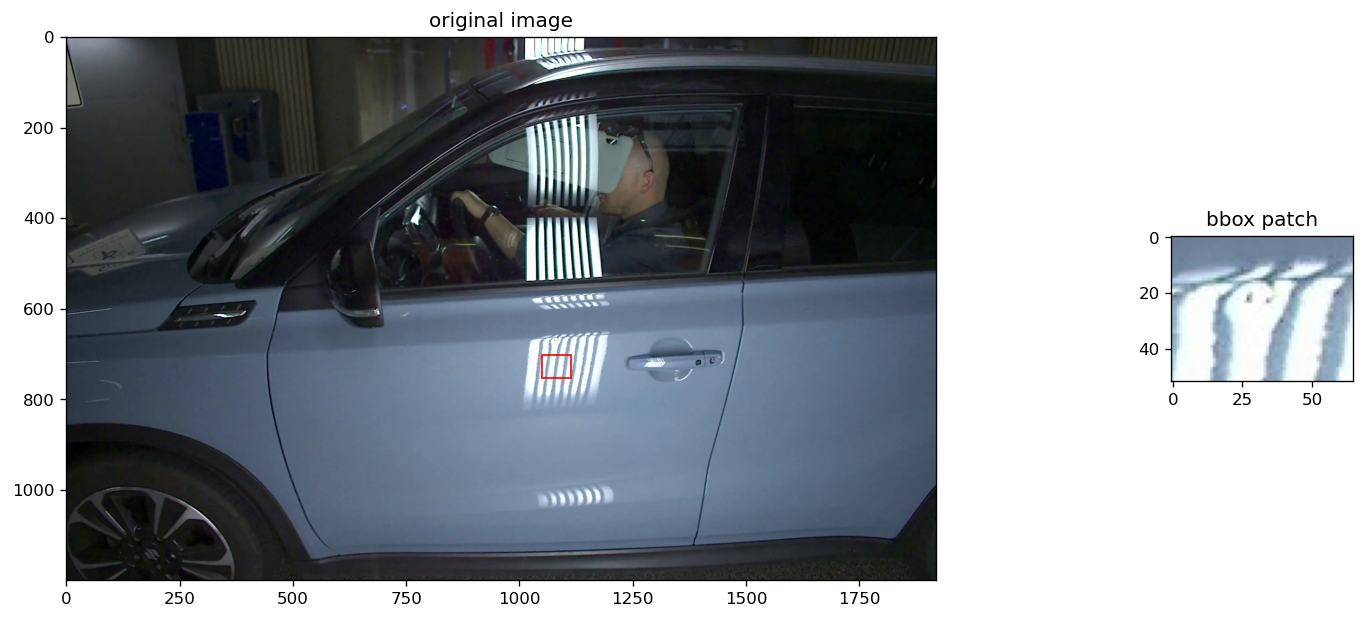

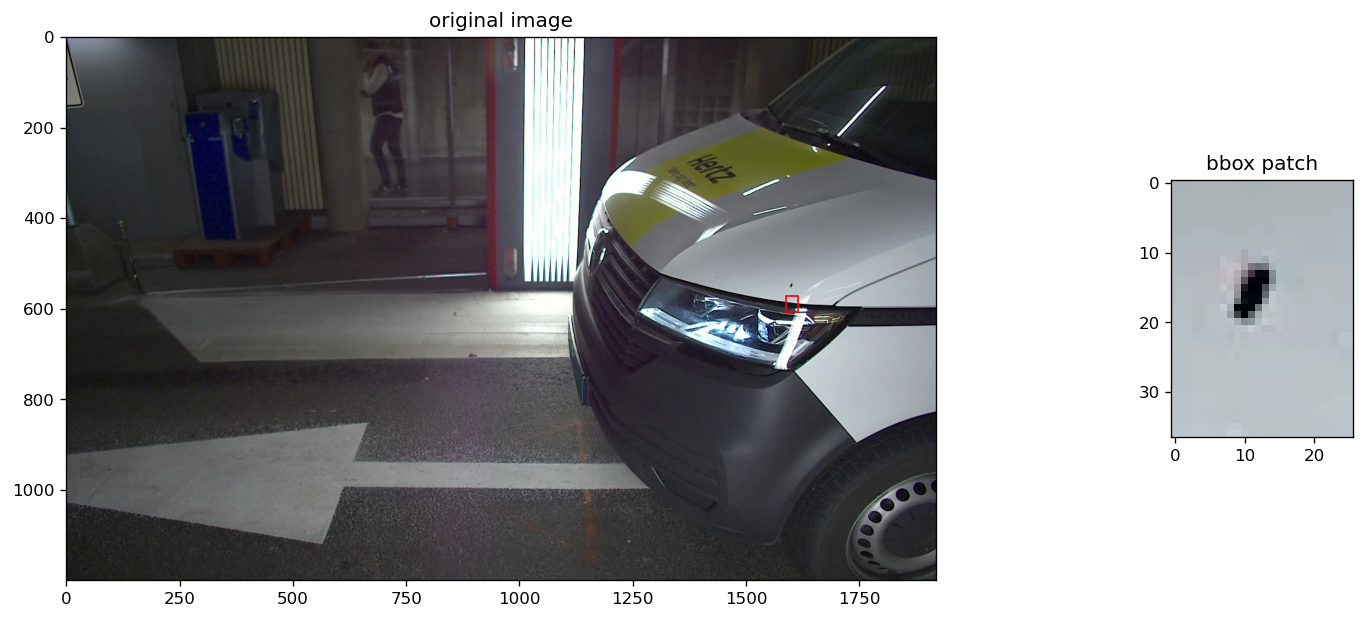

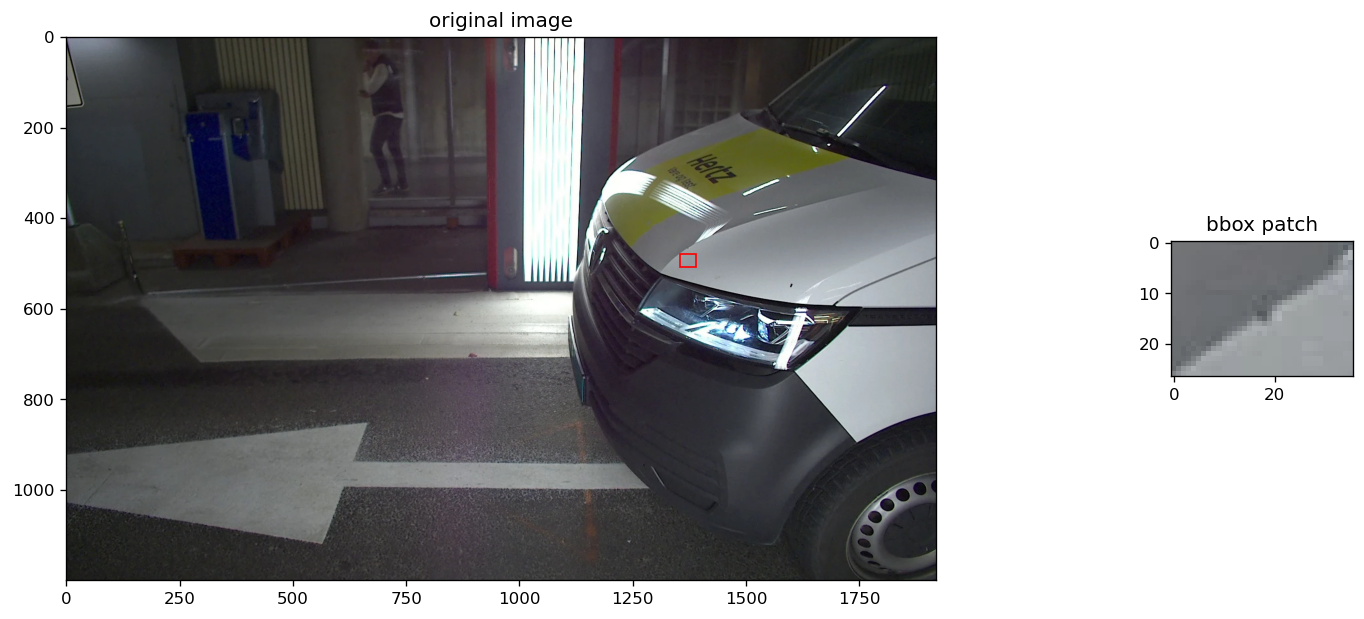

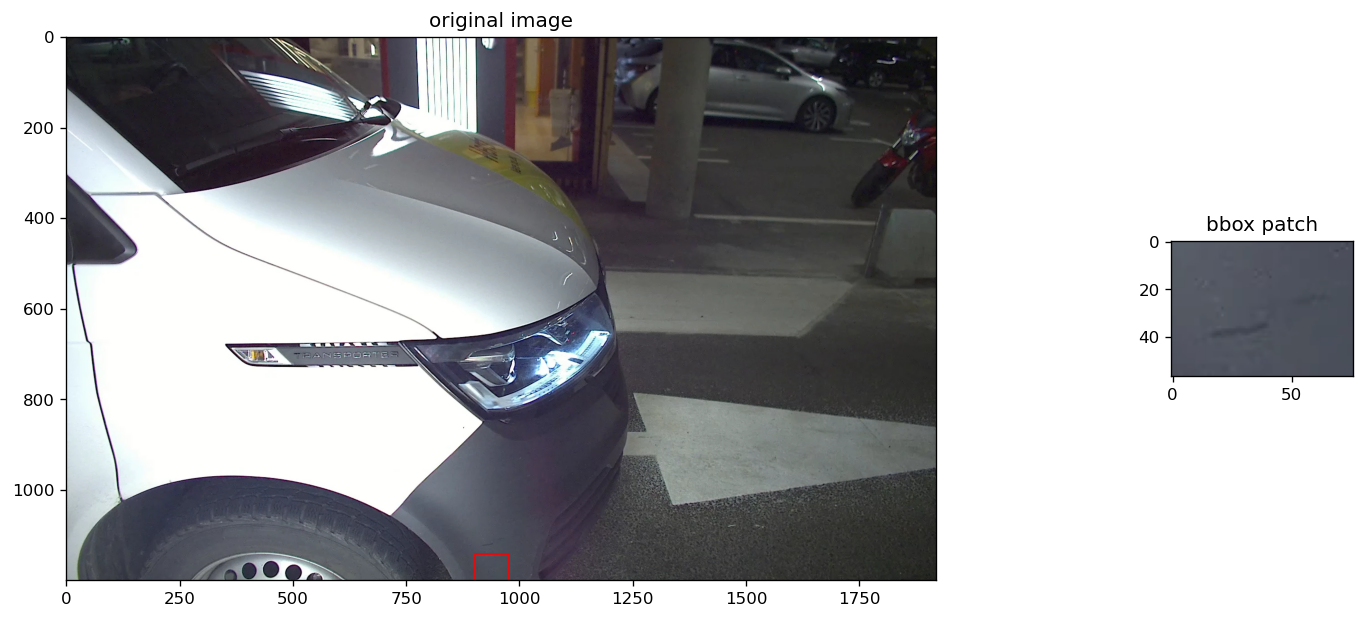

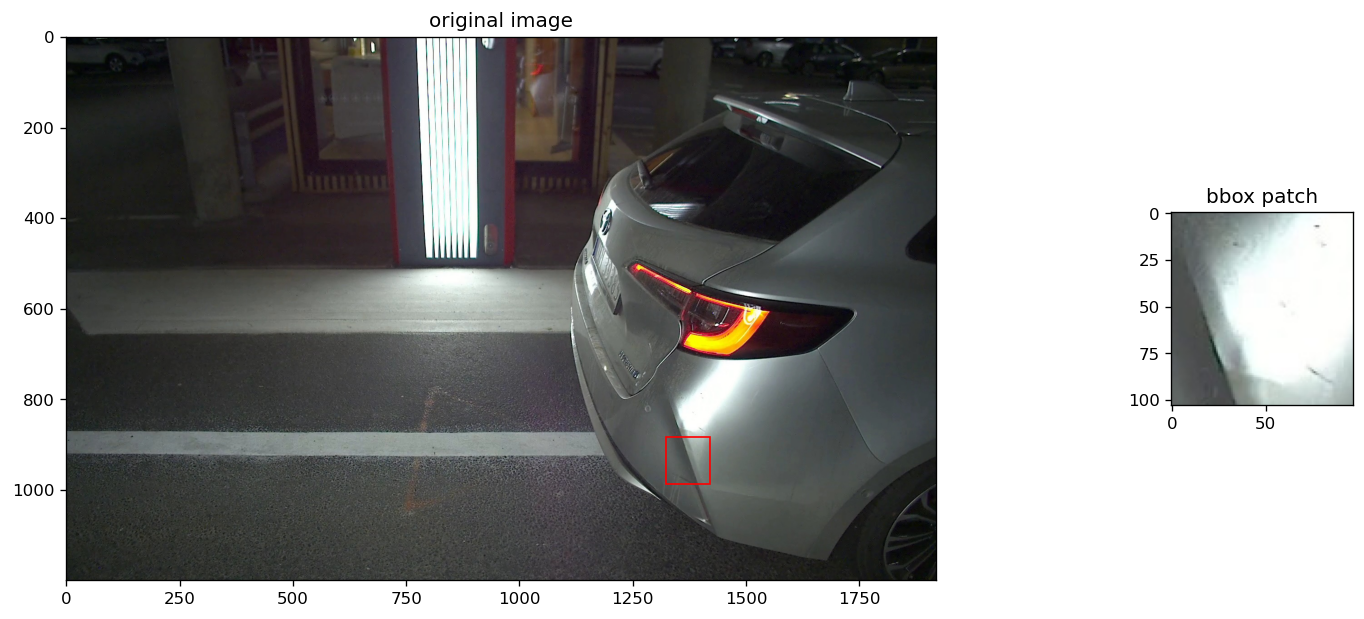

In [59]:
label_dict = {'1': 'Rim', '2': 'Scratch', '3': 'Dent', '4': 'Other'}   # dictionary{label:name} 
save_label = pd.DataFrame(columns=['image_id', 'id', 'human_label', 'label_name'])

tmp = data_bbox.iloc[:5,:]  # the number of images that you want to label

for i,name in tmp.iterrows():

    # get one row in data_bbox
    img_path = os.path.join(root_directory, 'Data', 'Images', name[0])
    [file_name, image_id, id, left, top, right, bottom, width, height] = name

    # prompt
    print(f'current image_id is {image_id} and current id is {id}')
    print('1: Rim, 2: Scratch, 3: Dent, 4: Other')

    # draw original image and bbox patch
    plt.ion()  # Turn the interactive mode on.
    figure, axis = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [6, 1]}, figsize=(15,6), dpi=120)
    img1 = Image.open(img_path)
    img2 = img1.crop((left, top, right, bottom))
    axis[0].imshow(img1)
    axis[0].add_patch(Rectangle((left,bottom), width, height, fc='none', color='red', linewidth=1, linestyle="-"))
    axis[0].set_title("original image")
    axis[1].imshow(img2)
    axis[1].set_title("bbox patch")

    # type label
    label = int(input("Please input a number: "))  # enter a number
    save_label.loc[i] = [image_id, id, label, label_dict[str(label)]]

save_label_path = os.path.join(root_directory, 'save_label.csv')
save_label_path1 = os.path.join(root_directory, 'save_label.json')
save_label.to_csv(save_label_path, index=False, header=True)
save_label.to_json(save_label_path1, orient='records')
print("file has already saved.")